## Confirm replicate quality for biological replicates obtained for all factors

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import glob
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import matplotlib.cm as cmap
import matplotlib
import matplotlib.patches as patches
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

sns.set_style('ticks')

#### set these variables:

In [2]:
home_dir = '/home/salma/Coding/scratch'

pipeline_dir = os.path.join(home_dir, 'pipeline_replicates')
plotting_dir = os.path.join(home_dir, 'plots/replicates')

#occupancies
analysis_dir = os.path.join(home_dir, 'analysis/co_occupancy_reps')

data_summary =  pd.read_table(os.path.join(home_dir, 'replicates.txt'), header=None)

sense_filename_TSS = 'non_overlapping_TSS/TIF_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
sense_filename_pA = 'non_overlapping_pA/TIF_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'

asense_filename_TSS = 'non_overlapping_TSS/TIF_NoOv_asense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_asense.table'
asense_filename_pA = 'non_overlapping_pA/TIF_NoOv_asense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_asense.table'

vlinepos = [1, 1000, 1751, 2501, 3499]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

### read tables

In [3]:
data_summary.columns = ['factor' , 'rep']
data_summary['name'] = [data_summary.factor[i] + '_' + str(data_summary.rep[i])  for i in range(len(data_summary))]

factors = data_summary.factor.unique()
replicates = data_summary.name

In [4]:
new_names = [s.split('_')[0] + ' Rep' + s.split('_')[1] for s in data_summary.name]

### correlation between occupancies

#### co-occupancy profiles are computed by the cluster

In [5]:
direc_names  = replicates

In [6]:
#build a matrix based on the co-occupancies calculated by cluster
co_occ = list()
for dir_occ in glob.glob(os.path.join(analysis_dir, "*.txt")):
    with open(dir_occ, 'r') as f:
        co_occ.append([float(i) for i in f.readlines()[0].split()])

factor_name = [os.path.basename(d).split('.')[0] for d in glob.glob(os.path.join(analysis_dir, "*.txt"))]
factor_name = [s.split('_')[0] + ' Rep' + s.split('_')[1] for s in factor_name]

occupancies = pd.DataFrame(co_occ, index=factor_name).reindex(new_names)

In [7]:
orig_cmap = cmap.hot
newcmap = LinearSegmentedColormap.from_list('newcmap', list(map(orig_cmap,np.linspace(-0.05, 1.5, 200))))

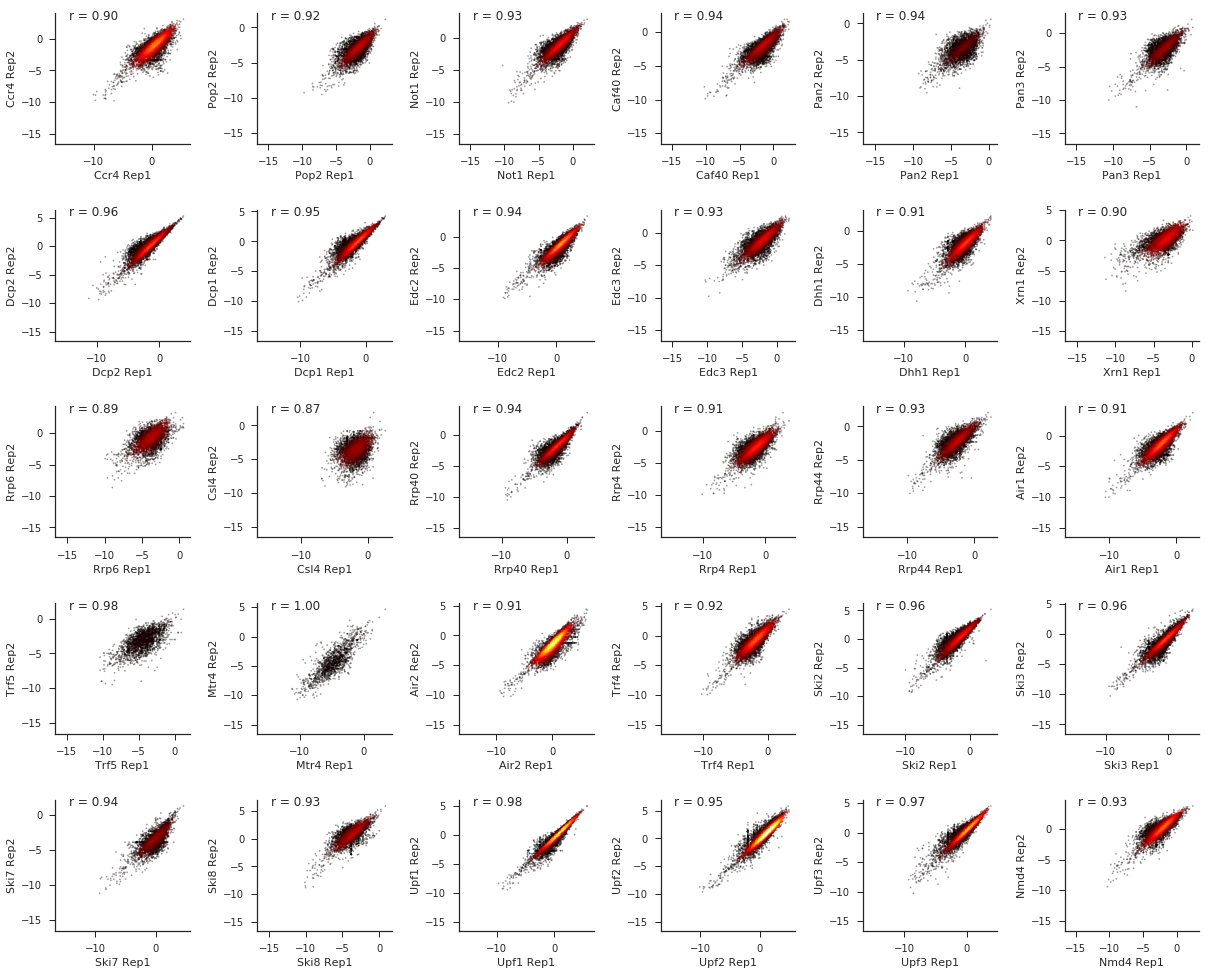

In [8]:
#log space

wspace = 0.5
hspace = 0.5
ncol = 6
nrow = 6
epsilon = 0.00001

plt.figure(figsize=(ncol*3+(ncol-1)*wspace,nrow*3+(nrow-1)*hspace))
plt.subplots_adjust(wspace=wspace, hspace=hspace)
sns.set_style("ticks")

for i, f in enumerate(factors):
    ax = plt.subplot(nrow,ncol,i+1)
    
    xaxis_ix = data_summary.loc[data_summary.factor==f,:].index.values[0]
    yaxis_ix = data_summary.loc[data_summary.factor==f,:].index.values[1]
    
    x = occupancies.iloc[xaxis_ix,:]
    y = occupancies.iloc[yaxis_ix,:]

        
    to_keep = [False]*len(x)
    for i in range(len(x)):
        if (x[i]>0) and (y[i]>0):
            to_keep[i] = True
        if (x[i]==0) and (y[i]==0):
            to_keep[i] = True

    x=x[to_keep].values
    y=y[to_keep].values
    
    x=np.log2(x+epsilon)
    y=np.log2(y+epsilon)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    ax.scatter(x, y, c=z, s=3, edgecolor='', cmap=newcmap, alpha=0.4)

    #enx = np.percentile(x,97.5)
    #eny = np.percentile(y,97.5)
    
    stx = np.percentile(x,5)
    sty = np.percentile(y,5)
    
    plt.xlim(stx, )
    plt.ylim(sty, )
    
    plt.xlabel(new_names[xaxis_ix])
    plt.ylabel(new_names[yaxis_ix])
    plt.locator_params(axis='y', nticks=2)
    plt.locator_params(axis='x', nticks=3)


    corr = spearmanr(x, y)[0]

    ax.text(0.1, 0.95, "r = {:.2f}".format(corr), transform=ax.transAxes, fontsize=12)
    sns.despine()
    
plt.savefig(os.path.join(plotting_dir,'occupancy_spearman_log2_newcmap.png'), dpi=300)
plt.savefig(os.path.join(plotting_dir,'occupancy_spearman_log2_newcmap.pdf'))

### CRAC metagene coverage

In [9]:
pipeline_dir_CRAC = os.path.join(home_dir,'CRAC','pipeline')
replicates_CRAC = ['Xrn1', 'Mtr4', 'Trf4','Ski2']

factors = ['Xrn1', 'Mtr4', 'Trf4','Ski2']

In [10]:
#read profiles from file: 
def read_profiles_CRAC(filename, replicates_CRAC):  
    profiles = list()
    for rep in replicates_CRAC:
        with open(os.path.join(pipeline_dir_CRAC , rep, 'postprocess', filename)) as f:
            profiles.append([float(i) for i in f.readlines()[0].split()])

    profiles = pd.DataFrame(profiles, index=replicates_CRAC)        
    normalized_profiles = profiles.apply(lambda x: ((x-min(x))/(max(x)-min(x))), axis=1) 

    return normalized_profiles

normalized_sense_profiles_TSS  = read_profiles_CRAC(sense_filename_TSS, replicates_CRAC)
normalized_sense_profiles_pA  = read_profiles_CRAC(sense_filename_pA, replicates_CRAC)
normalized_asense_profiles_TSS = read_profiles_CRAC(asense_filename_TSS, replicates_CRAC)
normalized_asense_profiles_pA  = read_profiles_CRAC(asense_filename_pA , replicates_CRAC)

In [11]:
def plot_metagene_heatmap_CRAC(filename, sense=True, cmap='RdYlBu_r', savefile = False, line_colour='black', skip=0):
    
    sns.set_style("ticks")
    
    vlinepos_lf = [0, 1000-skip]
    vlinepos_rt = [751, 1750-skip]

    figw = 6
    figh = len(replicates_CRAC)*0.5

    height_ratios = [sum([factor==f for factor in factors]) for f in ['Xrn1', 'Mtr4', 'Trf4', 'Ski2']]

    gridspec_kw = {"height_ratios":height_ratios, "width_ratios":[1,1]}
    heatmapkws = dict(square=False, cbar=False, cmap = cmap, linewidths=0.0, vmin=0.05, vmax=0.95) 
    tickskw =  dict(xticklabels=False, yticklabels=True)

    left = 0.07; right=0.87
    bottom = 0.1; top = 0.9

    print(len(height_ratios))
    fig, axes = plt.subplots(ncols=2, nrows=len(height_ratios), figsize=(figw, figh), gridspec_kw=gridspec_kw)
    plt.subplots_adjust(left=left, right=right,bottom=bottom, top=top, wspace=0.02, hspace=0.15)

    cumsum = np.cumsum(height_ratios)

    w = len(normalized_sense_profiles_TSS.iloc[0,:])
    #left
    if sense:
        profiles = normalized_sense_profiles_TSS
    else:
        profiles = normalized_asense_profiles_TSS
        
    sns.heatmap(profiles.iloc[0:cumsum[0],skip:int(w/2 +1)], ax=axes[0,0], xticklabels=False, 
                yticklabels=False, rasterized=True, robust=True, **heatmapkws)

    for i in range(1,len(cumsum)):    
        sns.heatmap(profiles.iloc[cumsum[i-1]:cumsum[i],skip:int(w/2 +1)], ax=axes[i,0], xticklabels=False, 
                    yticklabels=False, rasterized=True, robust=True, **heatmapkws)

    for i in range(len(cumsum)):
        axes[i,0].vlines(vlinepos_lf[0], *axes[i,0].get_ylim())
        axes[i,0].vlines(vlinepos_lf[1], *axes[i,0].get_ylim(), color=line_colour, linewidth=3)
        axes[i,0].hlines(list(axes[i,0].get_ylim()), *axes[i,0].get_xlim())
        axes[i,0].set_visible(True)
        axes[i,0].vlines([1751-skip], *axes[i,0].get_ylim(), linestyles='-', colors='White')
        axes[i,0].vlines([1751-skip], *axes[i,0].get_ylim(), linestyles='dashed')


    #right
    if sense:
        profiles = normalized_sense_profiles_pA
    else:
        profiles = normalized_asense_profiles_pA
    
    sns.heatmap(profiles.iloc[0:cumsum[0],int(w/2 +1):w-skip], ax=axes[0,1], xticklabels=False, 
                yticklabels=True, rasterized=True, robust=True, **heatmapkws)

    for i in range(1,len(cumsum)):    
        sns.heatmap(profiles.iloc[cumsum[i-1]:cumsum[i],int(w/2 +1):w-skip], ax=axes[i,1], xticklabels=False, 
                    yticklabels=True, rasterized=True, robust=True, **heatmapkws)

    for i in range(len(cumsum)):
        axes[i,1].vlines(vlinepos_rt, *axes[i,1].get_ylim())
        axes[i,1].vlines(vlinepos_rt[0], *axes[i,1].get_ylim(), color=line_colour, linewidth=3)
        axes[i,1].hlines(list(axes[i,1].get_ylim()), *axes[i,1].get_xlim())
        axes[i,1].set_visible(True)
        axes[i,1].yaxis.tick_right()
        axes[i,1].yaxis.set_label_position('right')
        axes[i,1].set_yticklabels(labels=axes[i,1].get_yticklabels() , rotation=0, fontsize=12) #weight='bold'
        axes[i,1].vlines([0], *axes[i,0].get_ylim(), linestyles='-', linewidth=2, colors='white')
        axes[i,1].vlines([0], *axes[i,0].get_ylim(), linestyles='--', linewidth=2, colors='black')
        

    if savefile:
        plt.savefig(os.path.join(plotting_dir, filename), bbox_inches='tight')
    plt.show()

4


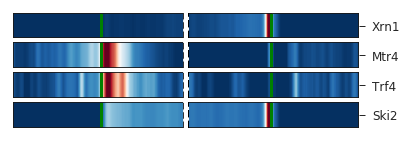

In [12]:
plot_metagene_heatmap_CRAC(sense=True, filename= 'sense_CRAC_merged_rdbu.pdf', cmap='RdBu_r', savefile=True, skip=200, line_colour='green')

4


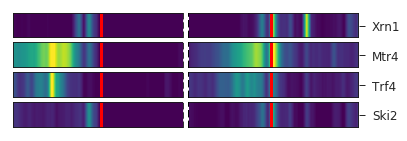

In [13]:
plot_metagene_heatmap_CRAC (sense=False, filename= 'asense_CRAC_viridis.pdf', cmap='viridis', savefile=True, skip=200, line_colour='red')

### PAR-CLIP metagene profiles

In [14]:
pipeline_dir_CRAC = os.path.join(home_dir,'pipeline')
replicates_CRAC = ['Xrn1', 'Mtr4', 'Trf4','Ski2']

factors = ['Xrn1', 'Mtr4', 'Trf4','Ski2']

In [15]:
#read profiles from file: 
def read_profiles_CRAC(filename, replicates_CRAC):  
    profiles = list()
    for rep in replicates_CRAC:
        with open(os.path.join(pipeline_dir_CRAC , rep, 'postprocess', filename)) as f:
            profiles.append([float(i) for i in f.readlines()[0].split()])

    profiles = pd.DataFrame(profiles, index=replicates_CRAC)        
    normalized_profiles = profiles.apply(lambda x: ((x-min(x))/(max(x)-min(x))), axis=1) 

    return normalized_profiles

normalized_sense_profiles_TSS  = read_profiles_CRAC(sense_filename_TSS, replicates_CRAC)
normalized_sense_profiles_pA  = read_profiles_CRAC(sense_filename_pA, replicates_CRAC)
normalized_asense_profiles_TSS = read_profiles_CRAC(asense_filename_TSS, replicates_CRAC)
normalized_asense_profiles_pA  = read_profiles_CRAC(asense_filename_pA , replicates_CRAC)

4


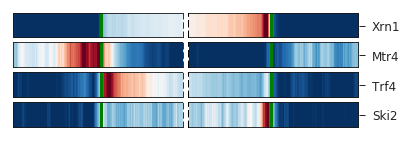

In [16]:
plot_metagene_heatmap_CRAC(sense=True, filename= 'sense_PC_merged_rdbu.pdf', cmap='RdBu_r', savefile=True, skip=200, line_colour='green')

4


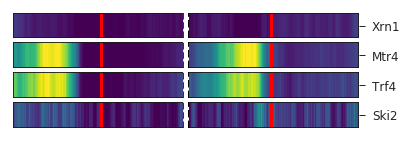

In [17]:
plot_metagene_heatmap_CRAC (sense=False, filename= 'asense_PC_merged_viridis.pdf', cmap='viridis', savefile=True, skip=200, line_colour='red')